# Setup

In [45]:

from core.controllers.base import IController
from core.perception.ocr.interface import OCRInterface
from core.perception.yolo.interface import IDetector

In [1]:
# --- Notebook bootstrap: imports & optional path setup ---

import os
import sys
from pathlib import Path

# If you opened the notebook at the repo root (where `core/` lives), this is enough.
repo_root = Path(os.getcwd())
print("Repo root assumed as:", repo_root)

# If for some reason you're running the notebook from another folder,
# you can manually force the repo root like this:
# repo_root = Path(r"C:\path\to\your\Umaplay\repo")
# os.chdir(repo_root)

if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

print("In sys.path?", str(repo_root) in sys.path)


Repo root assumed as: d:\GitHub\UmAutoplay
In sys.path? True


In [2]:
# --- Core project imports ---

from core.controllers.steam import SteamController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.settings import Settings
from core.utils.logger import logger_uma


In [4]:
# --- Light Settings tuning for the notebook ---

from pathlib import Path

# Where you want debug images / logs to go from this notebook
Settings.DEBUG = True
Settings.DEBUG_DIR = repo_root / "debug_notebook"

# Make sure the directory exists
Settings.DEBUG_DIR.mkdir(parents=True, exist_ok=True)

# (Optional) force some YOLO defaults for this notebook
Settings.YOLO_IMGSZ = 832
Settings.YOLO_CONF = 0.45
Settings.YOLO_IOU = 0.45

print("DEBUG_DIR:", Settings.DEBUG_DIR)
print("YOLO weights (URA):", Settings.YOLO_WEIGHTS_UNITY_CUP)
print("USE_GPU:", Settings.USE_GPU)


DEBUG_DIR: d:\GitHub\UmAutoplay\debug_notebook
YOLO weights (URA): D:\GitHub\UmAutoplay\models\uma_unity_cup.pt
USE_GPU: True


Focus success: True
Screenshot size: (645, 726)


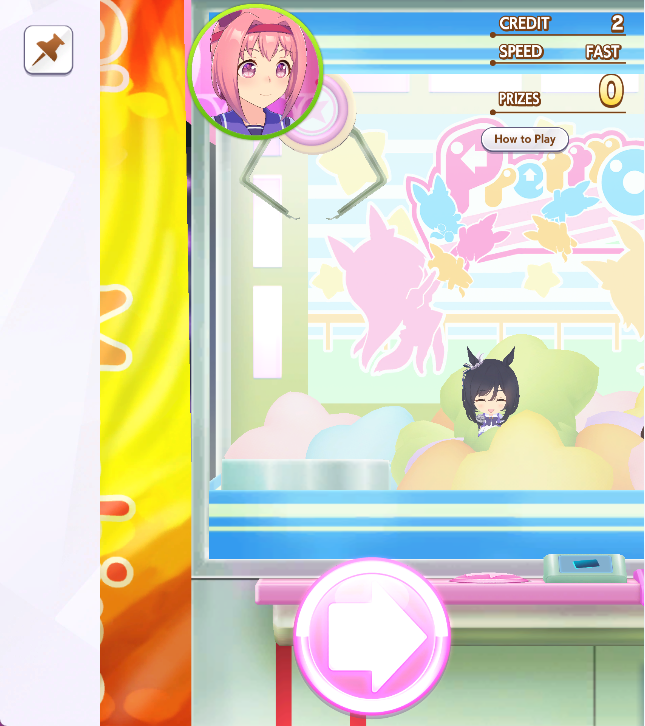

In [5]:
# --- Instantiate controller and test a screenshot ---

from IPython.display import display

# Use the exact window title; adjust if yours is different in Steam
ctrl = SteamController(window_title="Umamusume", capture_client_only=True)

focused = ctrl.focus()
print("Focus success:", focused)

# Take a screenshot of the left half (where the UI usually lives)
img = ctrl.screenshot_left_half()
print("Screenshot size:", img.size)

display(img)


In [7]:
# --- Instantiate LocalYOLOEngine bound to this controller ---

yolo_engine = LocalYOLOEngine(ctrl=ctrl, weights="models/uma_unity_cup.pt")

print("YOLO engine ready. Weights:", yolo_engine.weights_path)


YOLO engine ready. Weights: models/uma_unity_cup.pt


In [8]:
# --- Single YOLO recognition: smoke test ---

img, meta, dets = yolo_engine.recognize(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    tag="notebook_smoke",
    agent="nb"
)

print("Image size:", img.size)
print("Detections:", len(dets))
print("Classes in this frame:", sorted(set(d["name"] for d in dets)))

# Print first 15 detections with basic info
for d in dets[:15]:
    print(f"{d['name']:20s} conf={d['conf']:.3f} xyxy={d['xyxy']}")


Image size: (645, 726)
Detections: 3
Classes in this frame: ['button_claw_action', 'claw', 'claw_plushie']
button_claw_action   conf=0.957 xyxy=(290.890380859375, 556.2968139648438, 451.4347229003906, 715.70263671875)
claw                 conf=0.948 xyxy=(239.16867065429688, 71.13988494873047, 386.77972412109375, 221.22564697265625)
claw_plushie         conf=0.913 xyxy=(460.4252624511719, 344.95928955078125, 522.9015502929688, 450.3925476074219)


In [9]:
# --- Helpers: center and convenience extraction for claw/plush/button ---

from typing import Dict, Tuple, Optional, List

Detection = Dict[str, object]
XYXY = Tuple[float, float, float, float]

def center_xy(xyxy: XYXY) -> Tuple[float, float]:
    x1, y1, x2, y2 = xyxy
    return (x1 + x2) * 0.5, (y1 + y2) * 0.5

def get_first(dets: List[Detection], name: str) -> Optional[Detection]:
    for d in dets:
        if d["name"] == name:
            return d
    return None

claw_det = get_first(dets, "claw")
plush_det = get_first(dets, "claw_plushie")
btn_det = get_first(dets, "button_claw_action")

print("Found claw? ", claw_det is not None)
print("Found plush?", plush_det is not None)
print("Found button?", btn_det is not None)

if claw_det:
    cx_claw, cy_claw = center_xy(claw_det["xyxy"])
    print(f"Claw center: x={cx_claw:.1f}, y={cy_claw:.1f}")

if plush_det:
    cx_plush, cy_plush = center_xy(plush_det["xyxy"])
    print(f"Plush center: x={cx_plush:.1f}, y={cy_plush:.1f}")


Found claw?  True
Found plush? True
Found button? True
Claw center: x=313.0, y=146.2
Plush center: x=491.7, y=397.7


In [10]:
# --- Measure recognize() loop latency for the claw screen ---

import time
import statistics as stats

num_iters = 8  # keep it small, we just want an idea

latencies = []
for i in range(num_iters):
    t0 = time.perf_counter()
    img_loop, meta_loop, dets_loop = yolo_engine.recognize(
        imgsz=Settings.YOLO_IMGSZ,
        conf=Settings.YOLO_CONF,
        iou=Settings.YOLO_IOU,
        tag="latency_test",
        agent="nb",
    )
    t1 = time.perf_counter()
    lat = t1 - t0
    latencies.append(lat)
    print(f"Iteration {i+1}/{num_iters}: {lat:.3f} s, dets={len(dets_loop)}")

print("\nLatency stats (seconds):")
print("  min:", min(latencies))
print("  max:", max(latencies))
print("  avg:", stats.mean(latencies))
print("  median:", stats.median(latencies))


Iteration 1/8: 0.130 s, dets=3
Iteration 2/8: 0.053 s, dets=3
Iteration 3/8: 0.046 s, dets=3
Iteration 4/8: 0.050 s, dets=3
Iteration 5/8: 0.051 s, dets=3
Iteration 6/8: 0.048 s, dets=3
Iteration 7/8: 0.050 s, dets=3
Iteration 8/8: 0.050 s, dets=3

Latency stats (seconds):
  min: 0.04555660008918494
  max: 0.13017160003073514
  avg: 0.059582000016234815
  median: 0.050079000007826835


In [ ]:
# --- Pure offline rail simulator: test a simple predictive release policy ---

from dataclasses import dataclass

@dataclass
class RailParams:
    x_start: float          # starting x position of claw
    x_target: float         # target item's x center
    v: float                # horizontal speed (px/s), assumed constant for now
    loop_latency: float     # time between captures/decisions (s)
    press_to_release_latency: float  # extra input latency (s) after deciding
    early_bias_px: float    # how many pixels early we want to release
    max_time: float = 6.0   # max hold time in seconds
    dt: float = 0.02        # simulation step in seconds (20ms)


def simulate_release(params: RailParams):
    """
    Returns (released, t_decision, x_decision, x_final, error) where:
      - released: bool, if the policy found a release time before timeout.
      - t_decision: simulation time when we said "release now".
      - x_decision: claw position at t_decision.
      - x_final: estimated claw position when the release actually happens.
      - error: x_final - x_target (positive => overshoot to the right).
    """
    t = 0.0
    x = params.x_start

    # Assume motion only to the right for now.
    # x(t) = x_start + v * t
    # We'll pretend at each step we run one recognize() and then update decision.

    while t < params.max_time:
        # "Observation" step: in real life you'd read x_claw from YOLO here.
        x = params.x_start + params.v * t

        # Simple predictive policy:
        # We predict where the claw will be after loop + press latency
        total_latency = params.loop_latency + params.press_to_release_latency
        x_pred = x + params.v * total_latency

        # We want x_pred to be close to (x_target - early_bias)
        release_threshold = params.x_target - params.early_bias_px

        if x_pred >= release_threshold:
            # Decide to release at time t
            t_decision = t
            x_decision = x

            # Real position at actual release moment:
            t_final = t_decision + total_latency
            x_final = params.x_start + params.v * t_final
            error = x_final - params.x_target
            return True, t_decision, x_decision, x_final, error

        # Advance simulation time
        t += params.dt

    # If we never hit the threshold, we "time out"
    x_final = params.x_start + params.v * params.max_time
    error = x_final - params.x_target
    return False, params.max_time, x_final, x_final, error


# --- Example usage with your real x_start/x_target and rough guesses ---

# Use centers from Cell 7 (re-run that cell if needed)
x_start = cx_claw      # current claw x
x_target = cx_plush    # current plush x

# Guess a speed (we'll adjust later once we measure from a real sweep)
# e.g., claw crosses ~400 px in ~2 seconds → 200 px/s
v_guess = 200.0  

# Use median latency from Cell 8
loop_latency_est = stats.median(latencies)  # from Cell 8
press_latency_est = 0.04                    # rough guess for input latency
early_bias_px = 20.0                        # "release this many px early"

params = RailParams(
    x_start=x_start,
    x_target=x_target,
    v=v_guess,
    loop_latency=loop_latency_est,
    press_to_release_latency=press_latency_est,
    early_bias_px=early_bias_px,
    max_time=6.0,
    dt=0.02,
)

released, t_decision, x_decision, x_final, error = simulate_release(params)

print("Released?", released)
print(f"Decision time: {t_decision:.3f} s")
print(f"x at decision: {x_decision:.1f}")
print(f"x at final (after latency): {x_final:.1f}")
print(f"Target x: {x_target:.1f}")
print(f"Error (x_final - target): {error:.1f} px")


In [14]:
# --- Visualization: draw claw/plush centers and a hypothetical final x --- #

from PIL import ImageDraw
from IPython.display import display

def draw_claw_debug(
    img,
    claw_det,
    plush_det,
    x_final: float = None,
    title: str = "",
):
    """
    Draws:
      - bounding boxes for button, claw, plush
      - vertical line at claw center (blue)
      - vertical line at plush center (red)
      - vertical line at hypothetical final x (green), if provided
    """
    img_dbg = img.copy()
    draw = ImageDraw.Draw(img_dbg)

    def rect(xyxy, color, width=3):
        x1, y1, x2, y2 = xyxy
        draw.rectangle([x1, y1, x2, y2], outline=color, width=width)

    def vline(x, color, width=2):
        if x is None:
            return
        X = int(x)
        draw.line([(X, 0), (X, img_dbg.height)], fill=color, width=width)

    # Recompute centers in case the globals changed
    cx_claw, _ = center_xy(claw_det["xyxy"])
    cx_plush, _ = center_xy(plush_det["xyxy"])

    # Boxes
    rect(claw_det["xyxy"], (65, 105, 225), width=3)   # royal blue
    rect(plush_det["xyxy"], (255, 99, 71), width=3)   # tomato

    # Vertical lines
    vline(cx_claw, (135, 206, 250), width=2)   # light blue → current claw
    vline(cx_plush, (255, 0, 0), width=2)      # red → target plush

    if x_final is not None:
        vline(x_final, (124, 252, 0), width=2) # green → hypothetical final pos

    # Optional title
    if title:
        draw.text((10, 10), title, fill=(255, 255, 255))

    display(img_dbg)


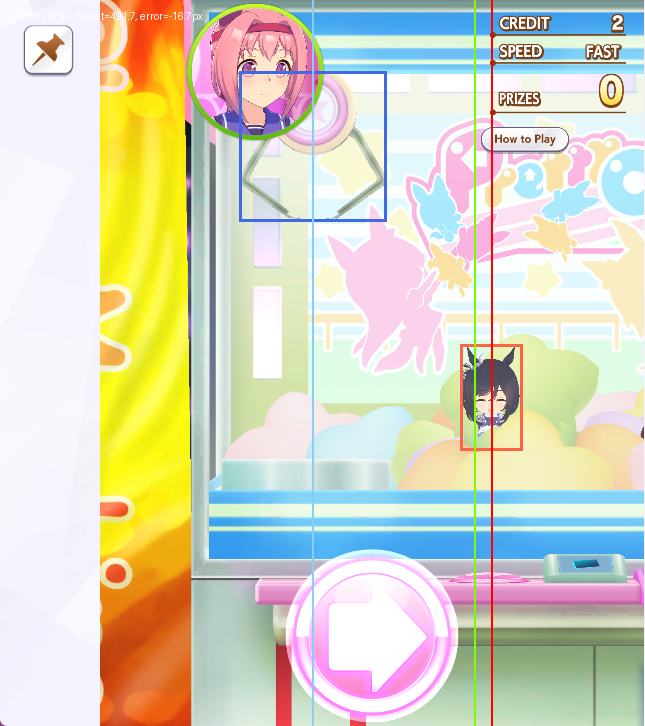

In [15]:
# Assuming you still have: img, claw_det, plush_det, x_final, error, x_target

title = f"x_final={x_final:.1f}, target={x_target:.1f}, error={error:.1f}px"
draw_claw_debug(img, claw_det, plush_det, x_final=x_final, title=title)


# Scan belt

In [52]:
# --- Simple belt scan: drag camera + capture YOLO --- #

import time
import pyautogui

def scan_belt_once(
    num_steps: int = 3,
    drag_pixels: int = 140,
    pause_s: float = 0.35,
):
    """
    Scans the claw belt by:
      - capturing the current view (step 0)
      - then num_steps-1 times:
          * dragging the view to the LEFT by drag_pixels
          * capturing again

    Returns: list of dicts with:
      - step index
      - image
      - detections
    """
    results = []

    # First capture (no dragging)
    img0, meta0, dets0 = yolo_engine.recognize(
        imgsz=Settings.YOLO_IMGSZ,
        conf=Settings.YOLO_CONF,
        iou=Settings.YOLO_IOU,
        tag="scan_step0",
        agent="nb",
    )
    results.append({"step": 0, "img": img0, "dets": dets0})

    print(f"[scan] step 0: dets={len(dets0)} "
          f"classes={sorted(set(d['name'] for d in dets0))}")

    # We will drag in the Y level of the plush (glass area) if possible.
    plush0 = get_first(dets0, "claw_plushie")
    if plush0:
        cx_p, cy_p = center_xy(plush0["xyxy"])
        drag_y = int(cy_p)
    else:
        # Fallback: vertical middle of the client area
        L, T, W, H = ctrl.left_half_bbox() or ctrl._client_bbox_screen_xywh()
        drag_y = int(T + H * 0.6)

    # Starting X = somewhere to the right of the plush (avoid buttons)
    # If we have the plush center, go a bit right of it
    if plush0:
        start_x = int(cx_p + 40)
    else:
        L, T, W, H = ctrl.left_half_bbox() or ctrl._client_bbox_screen_xywh()
        start_x = int(L + W * 0.7)

    for step in range(1, num_steps):
        # Move to starting point and drag LEFT
        pyautogui.moveTo(start_x, drag_y)
        pyautogui.dragRel(-drag_pixels, 0, duration=0.25, button="left")

        time.sleep(pause_s)

        img_s, meta_s, dets_s = yolo_engine.recognize(
            imgsz=Settings.YOLO_IMGSZ,
            conf=Settings.YOLO_CONF,
            iou=Settings.YOLO_IOU,
            tag=f"scan_step{step}",
            agent="nb",
        )

        results.append({"step": step, "img": img_s, "dets": dets_s})

        print(f"[scan] step {step}: dets={len(dets_s)} "
              f"classes={sorted(set(d['name'] for d in dets_s))}")

    return results


[scan] step 0: dets=3 classes=['button_claw_action', 'claw', 'claw_plushie']
[scan] step 1: dets=4 classes=['button_claw_action', 'claw_plushie']
[scan] step 2: dets=2 classes=['button_claw_action', 'claw_plushie']

Captured pages: 3

--- Page 0 ---
Plushies in this view: 1
  center=(521.5, 412.4) xyxy=(477.40679931640625, 376.3597106933594, 565.5175170898438, 448.5075988769531)


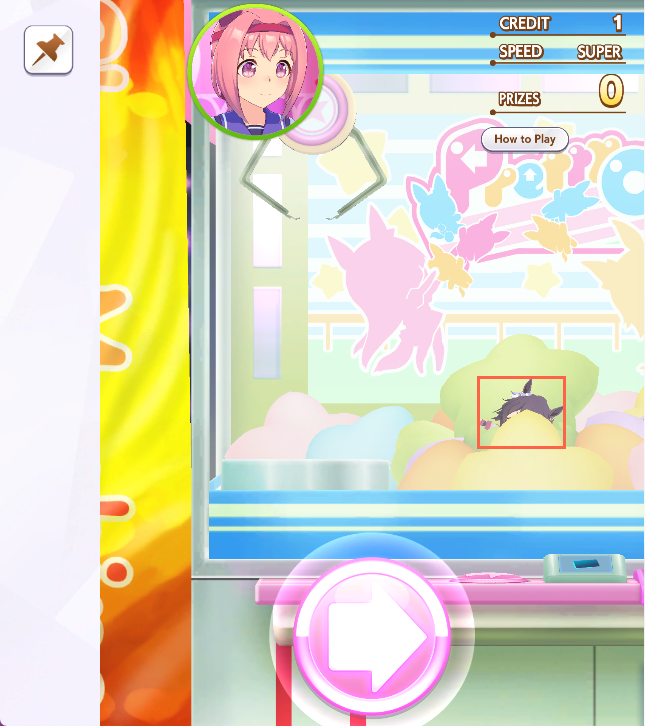


--- Page 1 ---
Plushies in this view: 3
  center=(393.7, 413.2) xyxy=(359.3077087402344, 363.5992126464844, 428.1000671386719, 462.7264404296875)
  center=(236.2, 411.6) xyxy=(192.61355590820312, 376.3178405761719, 279.8416442871094, 446.8427734375)
  center=(590.0, 406.4) xyxy=(535.5941162109375, 376.69244384765625, 644.4835205078125, 436.1551513671875)


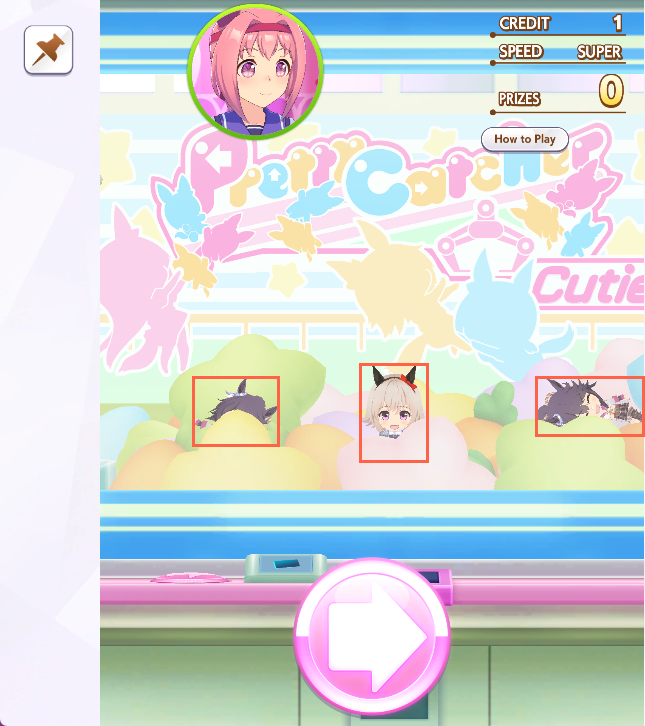


--- Page 2 ---
Plushies in this view: 1
  center=(310.9, 407.2) xyxy=(255.40211486816406, 377.7612609863281, 366.3388366699219, 436.5843811035156)


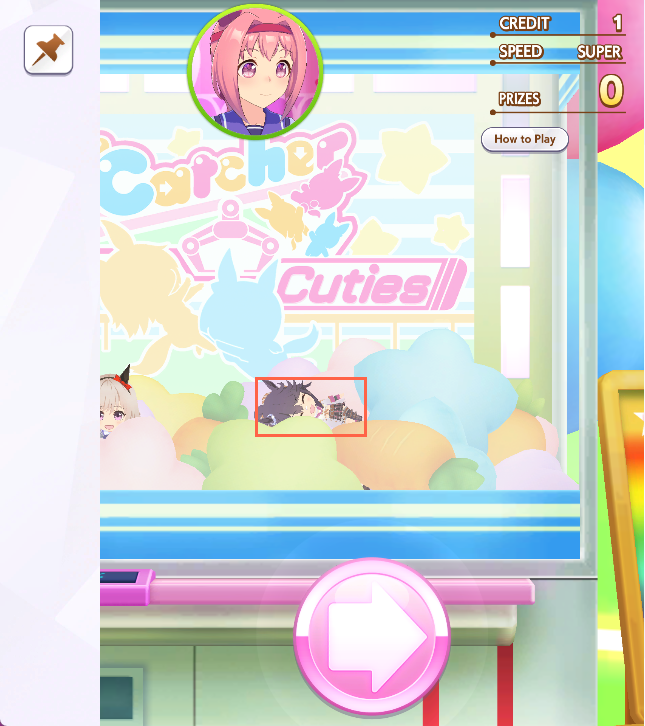

In [53]:
scan_results = scan_belt_once(num_steps=3, drag_pixels=140, pause_s=0.35)

print("\nCaptured pages:", len(scan_results))

for page in scan_results:
    step = page["step"]
    img_p = page["img"]
    dets_p = page["dets"]

    # Find all plushies in this view
    plushes = [d for d in dets_p if d["name"] == "claw_plushie"]

    print(f"\n--- Page {step} ---")
    print(f"Plushies in this view: {len(plushes)}")
    for d in plushes:
        cx, cy = center_xy(d["xyxy"])
        print(f"  center=({cx:.1f}, {cy:.1f}) xyxy={d['xyxy']}")

    # Draw quick debug image (boxes around plushies)
    img_dbg = img_p.copy()
    draw = ImageDraw.Draw(img_dbg)
    for d in plushes:
        x1, y1, x2, y2 = d["xyxy"]
        draw.rectangle([x1, y1, x2, y2], outline=(255, 99, 71), width=3)

    display(img_dbg)


# Normalize scan results

In [54]:
# --- Cell 1: Normalize scan_results into pages with plush detections --- #

from dataclasses import dataclass, field
from typing import List, Tuple, Dict
import numpy as np
from PIL import Image
import cv2

@dataclass
class PagePlush:
    page_idx: int
    det_idx: int
    bbox: Tuple[float, float, float, float]  # (x1,y1,x2,y2) in that page's coords
    cx: float
    cy: float

@dataclass
class ScanPage:
    step: int                     # scan step (0,1,2,...)
    img: Image.Image
    plushes: List[PagePlush]

# helper you already had, repeated here for clarity
def center_xy(xyxy: Tuple[float, float, float, float]) -> Tuple[float, float]:
    x1, y1, x2, y2 = xyxy
    return (x1 + x2) * 0.5, (y1 + y2) * 0.5

pages: List[ScanPage] = []

for page in scan_results:  # scan_results from your previous scan cell
    step = page["step"]
    img_p = page["img"]
    dets_p = page["dets"]

    plushes_p: List[PagePlush] = []
    for i, d in enumerate(dets_p):
        if d["name"] != "claw_plushie":
            continue
        cx, cy = center_xy(d["xyxy"])
        plushes_p.append(
            PagePlush(
                page_idx=step,
                det_idx=i,
                bbox=d["xyxy"],
                cx=cx,
                cy=cy,
            )
        )

    pages.append(ScanPage(step=step, img=img_p, plushes=plushes_p))

# Ensure pages are sorted by scan step
pages.sort(key=lambda p: p.step)

print("Pages and plush counts:")
for p in pages:
    print(f"  step={p.step}: {len(p.plushes)} plush(es)")
    for pl in p.plushes:
        print(f"    det_idx={pl.det_idx}, cx={pl.cx:.1f}, cy={pl.cy:.1f}")


Pages and plush counts:
  step=0: 1 plush(es)
    det_idx=2, cx=521.5, cy=412.4
  step=1: 3 plush(es)
    det_idx=1, cx=393.7, cy=413.2
    det_idx=2, cx=236.2, cy=411.6
    det_idx=3, cx=590.0, cy=406.4
  step=2: 1 plush(es)
    det_idx=1, cx=310.9, cy=407.2


In [55]:
# Cell 1 – Physical plush tracking with 1↔1 matching per page

from dataclasses import dataclass, field
from typing import List, Dict, Tuple
import numpy as np
import cv2
from PIL import Image

@dataclass
class PhysicalPlush:
    phys_id: int
    members: List[PagePlush] = field(default_factory=list)


def crop_patch(page: ScanPage, plush: PagePlush, pad_frac: float = 0.15) -> Image.Image:
    """Crop a padded patch around the plush, clamped to the image bounds."""
    x1, y1, x2, y2 = plush.bbox
    w = x2 - x1
    h = y2 - y1
    cx, cy = plush.cx, plush.cy

    pad_x = w * pad_frac
    pad_y = h * pad_frac

    left   = int(max(0, cx - w / 2 - pad_x))
    right  = int(min(page.img.width,  cx + w / 2 + pad_x))
    top    = int(max(0, cy - h / 2 - pad_y))
    bottom = int(min(page.img.height, cy + h / 2 + pad_y))

    return page.img.crop((left, top, right, bottom))


def patch_similarity(patch_a: Image.Image, patch_b: Image.Image) -> float:
    """Cosine similarity between two patches (grayscale, normalized)."""
    a = np.array(patch_a)
    b = np.array(patch_b)

    a = cv2.cvtColor(a, cv2.COLOR_RGB2GRAY)
    b = cv2.cvtColor(b, cv2.COLOR_RGB2GRAY)

    target_size = (64, 64)
    a = cv2.resize(a, target_size, interpolation=cv2.INTER_AREA)
    b = cv2.resize(b, target_size, interpolation=cv2.INTER_AREA)

    a = a.astype(np.float32)
    b = b.astype(np.float32)

    a = (a - a.mean()) / (a.std() + 1e-6)
    b = (b - b.mean()) / (b.std() + 1e-6)

    num = float((a * b).sum())
    den = float(np.sqrt((a * a).sum() * (b * b).sum()) + 1e-6)
    return num / den


def build_physical_plushes(pages: List[ScanPage], sim_threshold: float = 0.60) -> List[PhysicalPlush]:
    """
    Group detections across pages into 'physical' plushes.

    Key points:
    - We only ever match CURRENT page against the PREVIOUS page.
    - Within a page we enforce 1↔1 matching between previous-phys and current dets.
    - Anything that doesn't match with enough similarity becomes a new physical plush.
    """
    physical: List[PhysicalPlush] = []
    next_id = 0

    # Cache cropped patches to avoid re-cropping
    patch_cache: Dict[Tuple[int, int], Image.Image] = {}

    def get_patch(page: ScanPage, plush: PagePlush) -> Image.Image:
        key = (page.step, plush.det_idx)
        if key not in patch_cache:
            patch_cache[key] = crop_patch(page, plush)
        return patch_cache[key]

    # Seed physical list with the first page
    first_page = pages[0]
    for pl in first_page.plushes:
        physical.append(PhysicalPlush(phys_id=next_id, members=[pl]))
        next_id += 1

    # Process subsequent pages
    for k in range(1, len(pages)):
        prev_page = pages[k - 1]
        cur_page  = pages[k]

        # Physical plushes that were visible in the previous page
        active_phys = [
            phys
            for phys in physical
            if any(m.page_idx == prev_page.step for m in phys.members)
        ]

        # Build all candidate (similarity, phys_idx, cur_idx) tuples
        candidates: List[Tuple[float, int, int]] = []

        for p_idx, phys in enumerate(active_phys):
            # Last appearance of this physical plush in prev_page
            last_prev = next(m for m in phys.members if m.page_idx == prev_page.step)
            patch_prev = get_patch(prev_page, last_prev)

            for c_idx, pl in enumerate(cur_page.plushes):
                patch_cur = get_patch(cur_page, pl)
                sim = patch_similarity(patch_prev, patch_cur)
                candidates.append((sim, p_idx, c_idx))

        # Greedy 1↔1 assignment based on similarity
        candidates.sort(reverse=True, key=lambda t: t[0])
        used_phys: set[int] = set()
        used_cur: set[int] = set()
        assignment: Dict[int, PhysicalPlush] = {}

        for sim, p_idx, c_idx in candidates:
            if sim < sim_threshold:
                break  # remaining pairs will be even worse
            if p_idx in used_phys or c_idx in used_cur:
                continue

            phys = active_phys[p_idx]
            assignment[c_idx] = phys
            used_phys.add(p_idx)
            used_cur.add(c_idx)

        # Apply assignments; unassigned detections become NEW physical plushes
        for c_idx, pl in enumerate(cur_page.plushes):
            phys = assignment.get(c_idx)
            if phys is None:
                phys = PhysicalPlush(phys_id=next_id, members=[pl])
                physical.append(phys)
                next_id += 1
            else:
                phys.members.append(pl)

    return physical


physical_plushes = build_physical_plushes(pages, sim_threshold=0.60)

print("Physical plush summary (after 1↔1 matching):")
for phys in physical_plushes:
    pages_seen = [m.page_idx for m in phys.members]
    xs = [m.cx for m in phys.members]
    print(f"  phys_id={phys.phys_id} | pages={pages_seen} | xs={['%.1f' % x for x in xs]}")


Physical plush summary (after 1↔1 matching):
  phys_id=0 | pages=[0, 1] | xs=['521.5', '236.2']
  phys_id=1 | pages=[1] | xs=['393.7']
  phys_id=2 | pages=[1] | xs=['590.0']
  phys_id=3 | pages=[2] | xs=['310.9']


Canonical step (densest view): 1 with 3 plush(es)

Physical plushes ordered left→right in the canonical view:
  phys_id=0 | belt_x=236.2 | seen_on_pages=[0, 1]
  phys_id=3 | belt_x=310.9 | seen_on_pages=[2]
  phys_id=1 | belt_x=393.7 | seen_on_pages=[1]
  phys_id=2 | belt_x=590.0 | seen_on_pages=[1]


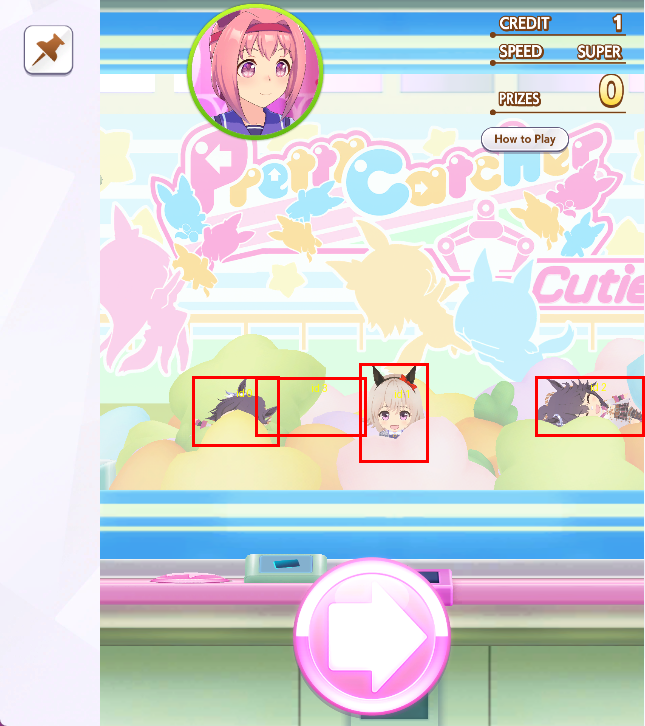

In [56]:
# Cell 2 – Canonical belt coordinate + visual check

from typing import Dict
from PIL import ImageDraw
from IPython.display import display

# 1) Find the densest page (most plushes at once)
densest_page = max(pages, key=lambda pg: len(pg.plushes))
canonical_step = densest_page.step
print(f"Canonical step (densest view): {canonical_step} "
      f"with {len(densest_page.plushes)} plush(es)")

# 2) For each physical plush, choose a canonical member
belt_records: List[Tuple[float, int]] = []  # (belt_x, phys_id)
canonical_member_for_phys: Dict[int, PagePlush] = {}

for phys in physical_plushes:
    # Prefer the member that appears in the canonical step
    same_step = [m for m in phys.members if m.page_idx == canonical_step]
    if same_step:
        canon = same_step[0]
    else:
        # Otherwise, use earliest appearance (smallest page_idx)
        canon = min(phys.members, key=lambda m: m.page_idx)

    canonical_member_for_phys[phys.phys_id] = canon
    belt_records.append((canon.cx, phys.phys_id))

# Sort left→right by canonical X
belt_records.sort(key=lambda t: t[0])

print("\nPhysical plushes ordered left→right in the canonical view:")
for cx, pid in belt_records:
    phys = next(p for p in physical_plushes if p.phys_id == pid)
    pages_seen = sorted({m.page_idx for m in phys.members})
    print(f"  phys_id={pid} | belt_x={cx:.1f} | seen_on_pages={pages_seen}")

# 3) Visual debug: draw phys IDs on the canonical screenshot
img_vis = densest_page.img.copy()
draw = ImageDraw.Draw(img_vis)

for cx, pid in belt_records:
    m = canonical_member_for_phys[pid]
    x1, y1, x2, y2 = m.bbox
    draw.rectangle((x1, y1, x2, y2), outline=(255, 0, 0), width=3)
    draw.text((m.cx, m.cy - 25), f"id {pid}", fill=(255, 255, 0))

display(img_vis)


In [57]:
# Cell 3 (fixed) – Aggregate features and get claw width from any scan page

from dataclasses import dataclass
from typing import List, Dict, Tuple

@dataclass
class PlushFeatures:
    phys_id: int
    belt_x: float             # X in canonical view (screen coords)
    mean_width: float
    mean_height: float
    aspect_ratio: float       # H / W
    pages_seen: List[int]
    appearances: int
    width_vs_claw: float      # width / claw_width (if claw found, else -1)


# 1) Find canonical (densest) page again
densest_page = max(pages, key=lambda pg: len(pg.plushes))
canonical_step = densest_page.step
print(f"Canonical step: {canonical_step} (plushes={len(densest_page.plushes)})")

# 2) Find claw width from ANY scan page that has a 'claw'
claw_w = None
claw_source_step = None

for page_dict in scan_results:   # scan_results from the scan loop
    step = page_dict["step"]
    dets = page_dict["dets"]
    claws_here = [d for d in dets if d["name"] == "claw"]
    if claws_here:
        x1, y1, x2, y2 = claws_here[0]["xyxy"]
        claw_w = x2 - x1
        claw_source_step = step
        break

if claw_w is not None:
    print(f"Estimated claw width: {claw_w:.1f} px (from step {claw_source_step})")
else:
    print("WARNING: No 'claw' found in any scan page; width_vs_claw will be -1.")

# 3) For each physical plush, choose its canonical member and aggregate stats
phys_feat: List[PlushFeatures] = []

for phys in physical_plushes:
    members = phys.members
    if not members:
        continue

    # Canonical member: prefer appearance in canonical_step, else earliest page
    same_step = [m for m in members if m.page_idx == canonical_step]
    if same_step:
        canon = same_step[0]
    else:
        canon = min(members, key=lambda m: m.page_idx)

    # Aggregate width/height across all appearances
    widths = []
    heights = []
    for m in members:
        x1, y1, x2, y2 = m.bbox
        widths.append(x2 - x1)
        heights.append(y2 - y1)

    mean_w = sum(widths) / len(widths)
    mean_h = sum(heights) / len(heights)
    aspect = mean_h / max(mean_w, 1e-6)

    if claw_w is not None:
        width_vs_claw = mean_w / claw_w
    else:
        width_vs_claw = -1.0

    pages_seen = sorted({m.page_idx for m in members})

    phys_feat.append(
        PlushFeatures(
            phys_id=phys.phys_id,
            belt_x=canon.cx,
            mean_width=mean_w,
            mean_height=mean_h,
            aspect_ratio=aspect,
            pages_seen=pages_seen,
            appearances=len(members),
            width_vs_claw=width_vs_claw,
        )
    )

# Sort by belt_x (left → right in canonical view)
phys_feat.sort(key=lambda f: f.belt_x)

print("\nPlush feature summary (left→right in canonical view):")
for f in phys_feat:
    print(
        f"  phys_id={f.phys_id} | x={f.belt_x:.1f} | asp={f.aspect_ratio:.2f} "
        f"| w_vs_claw={f.width_vs_claw:.2f} | pages={f.pages_seen} | "
        f"occ={f.appearances}"
    )


Canonical step: 1 (plushes=3)
Estimated claw width: 147.8 px (from step 0)

Plush feature summary (left→right in canonical view):
  phys_id=0 | x=236.2 | asp=0.81 | w_vs_claw=0.59 | pages=[0, 1] | occ=2
  phys_id=3 | x=310.9 | asp=0.53 | w_vs_claw=0.75 | pages=[2] | occ=1
  phys_id=1 | x=393.7 | asp=1.44 | w_vs_claw=0.47 | pages=[1] | occ=1
  phys_id=2 | x=590.0 | asp=0.55 | w_vs_claw=0.74 | pages=[1] | occ=1


Plush scores (best first):
  phys_id=1 | score=2.93 | x=393.7 | w_vs_claw=0.47 | asp=1.44 | pages=[1]
  phys_id=0 | score=2.41 | x=236.2 | w_vs_claw=0.59 | asp=0.81 | pages=[0, 1]
  phys_id=3 | score=0.99 | x=310.9 | w_vs_claw=0.75 | asp=0.53 | pages=[2]
  phys_id=2 | score=-0.27 | x=590.0 | w_vs_claw=0.74 | asp=0.55 | pages=[1]

Chosen target phys_id=1 (score=2.93)


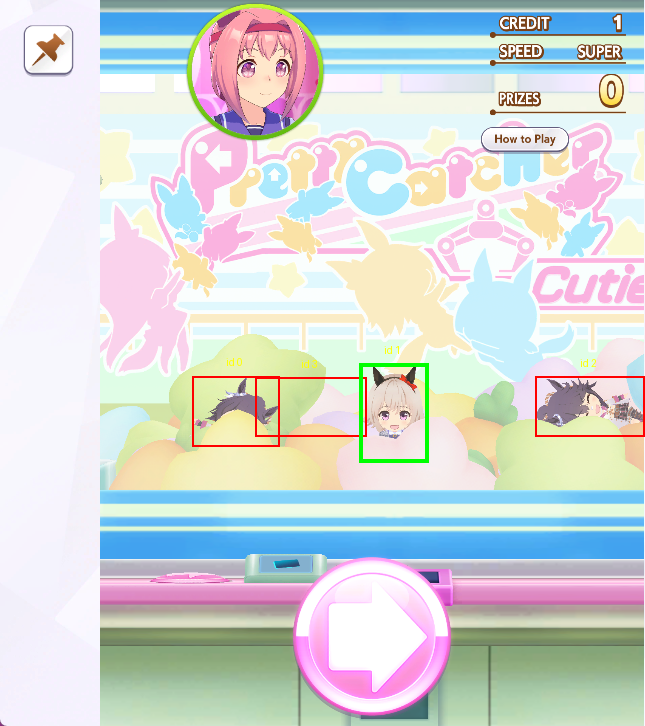

In [58]:
# Cell 4 – Target selection + visual debug

from PIL import ImageDraw
from IPython.display import display

if not phys_feat:
    print("No plush features available; run Cell 3 first.")
else:
    img_w, img_h = densest_page.img.size
    center_x = img_w / 2

    def score_plush(f: PlushFeatures) -> float:
        score = 0.0

        # thin vs claw → easier grab
        if f.width_vs_claw > 0 and f.width_vs_claw <= 0.6:
            score += 2.0
        elif f.width_vs_claw > 0 and f.width_vs_claw <= 0.9:
            score += 1.0

        # tall-ish shape (plush higher than wide)
        if f.aspect_ratio >= 1.1:
            score += 1.0
        elif f.aspect_ratio >= 0.9:
            score += 0.5

        # appears in more scan pages (visible for longer segment of the belt)
        score += 0.5 * (len(f.pages_seen) - 1)

        # edge penalty: prefer not being right at extremes of the visible belt
        dist_left  = max(0.0, f.belt_x)
        dist_right = max(0.0, img_w - f.belt_x)
        min_edge_dist = min(dist_left, dist_right)
        # If very close to an edge (< 120 px), penalize
        if min_edge_dist < 120:
            score -= 1.0
        elif min_edge_dist < 200:
            score -= 0.5

        # mild center preference
        dist_center = abs(f.belt_x - center_x)
        score -= 0.001 * dist_center  # tiny effect

        return score

    # Compute scores
    scores = [(score_plush(f), f) for f in phys_feat]
    scores.sort(reverse=True, key=lambda t: t[0])

    print("Plush scores (best first):")
    for s, f in scores:
        print(
            f"  phys_id={f.phys_id} | score={s:.2f} | x={f.belt_x:.1f} "
            f"| w_vs_claw={f.width_vs_claw:.2f} | asp={f.aspect_ratio:.2f} "
            f"| pages={f.pages_seen}"
        )

    best_score, best = scores[0]
    print(f"\nChosen target phys_id={best.phys_id} (score={best_score:.2f})")

    # Visual debug on canonical frame
    img_dbg = densest_page.img.copy()
    draw = ImageDraw.Draw(img_dbg)

    for f in phys_feat:
        # find one member in canonical_step (or earliest if not there)
        phys = next(p for p in physical_plushes if p.phys_id == f.phys_id)
        same_step = [m for m in phys.members if m.page_idx == canonical_step]
        if same_step:
            m = same_step[0]
        else:
            m = min(phys.members, key=lambda m: m.page_idx)

        x1, y1, x2, y2 = m.bbox

        if f.phys_id == best.phys_id:
            color = (0, 255, 0)   # green for chosen
            width = 4
        else:
            color = (255, 0, 0)   # red for others
            width = 2

        draw.rectangle((x1, y1, x2, y2), outline=color, width=width)
        draw.text((f.belt_x - 10, y1 - 20), f"id {f.phys_id}", fill=(255, 255, 0))

    display(img_dbg)


Start view step (claw visible): 0
Claw center in start view: (312.9, 146.1)
Target phys_id=1 center in step 1: (393.7, 413.2)
Initial horizontal gap (target - claw): dx_start = 80.8 px


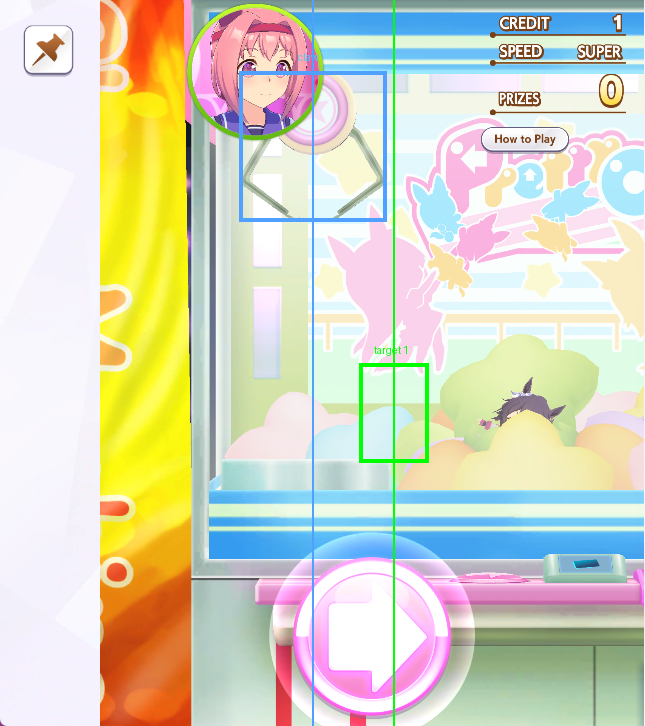

In [59]:
# Cell 5 – Map chosen target to the start (claw) view and inspect geometry

from typing import Optional
from PIL import ImageDraw
from IPython.display import display

# 1) Find which scan step contains the claw – this will be our "start view".
start_step: Optional[int] = None
start_page_img = None
start_page_dets = None

for page in scan_results:
    step = page["step"]
    dets = page["dets"]
    claws = [d for d in dets if d["name"] == "claw"]
    if claws:
        start_step = step
        start_page_img = page["img"]
        start_page_dets = dets
        break

if start_step is None:
    print("ERROR: No 'claw' found in any scan page; cannot define start view.")
else:
    print(f"Start view step (claw visible): {start_step}")

# 2) Get claw center in this start view
if start_step is not None:
    claws = [d for d in start_page_dets if d["name"] == "claw"]
    claw_xyxy = claws[0]["xyxy"]
    cx_claw = 0.5 * (claw_xyxy[0] + claw_xyxy[2])
    cy_claw = 0.5 * (claw_xyxy[1] + claw_xyxy[3])
    print(f"Claw center in start view: ({cx_claw:.1f}, {cy_claw:.1f})")

# 3) Find the chosen physical plush and its member in the start step
target_phys_id = best.phys_id  # from the scoring cell

target_phys = next(p for p in physical_plushes if p.phys_id == target_phys_id)

member_start: Optional[PagePlush] = None
for m in target_phys.members:
    if m.page_idx == start_step:
        member_start = m
        break

if member_start is None:
    print(
        f"WARNING: Target phys_id={target_phys_id} does not appear in the "
        f"start step {start_step}. We'll use its earliest appearance instead."
    )
    member_start = min(target_phys.members, key=lambda m: m.page_idx)

# 4) Target center in that view
x1_t, y1_t, x2_t, y2_t = member_start.bbox
cx_target = 0.5 * (x1_t + x2_t)
cy_target = 0.5 * (y1_t + y2_t)

print(
    f"Target phys_id={target_phys_id} center in step {member_start.page_idx}: "
    f"({cx_target:.1f}, {cy_target:.1f})"
)

# 5) Horizontal gap between claw and target in the start view
if start_step is not None:
    dx_start = cx_target - cx_claw
    print(f"Initial horizontal gap (target - claw): dx_start = {dx_start:.1f} px")

# 6) Visual debug: draw claw + target on the start view
if start_page_img is not None:
    img_dbg = start_page_img.copy()
    draw = ImageDraw.Draw(img_dbg)

    # Draw claw (blue)
    x1_c, y1_c, x2_c, y2_c = claw_xyxy
    draw.rectangle((x1_c, y1_c, x2_c, y2_c), outline=(80, 160, 255), width=4)
    draw.text((cx_claw - 15, y1_c - 20), "claw", fill=(80, 200, 255))

    # Draw target plush (green)
    draw.rectangle((x1_t, y1_t, x2_t, y2_t), outline=(0, 255, 0), width=4)
    draw.text((cx_target - 20, y1_t - 20), f"target {target_phys_id}", fill=(0, 255, 0))

    # Optional: small vertical marker lines at each center
    draw.line([(cx_claw, 0), (cx_claw, img_dbg.height)], fill=(80, 160, 255), width=2)
    draw.line([(cx_target, 0), (cx_target, img_dbg.height)], fill=(0, 255, 0), width=2)

    display(img_dbg)


# Rail simulation

In [34]:
# Cell 6 – 1D rail simulator with latency-aware release policy

import numpy as np
from typing import Dict, Any

# Sanity check: these should come from Cell 5
print(f"cx_claw  = {cx_claw:.1f}")
print(f"cx_target= {cx_target:.1f}")
print(f"dx_start = {dx_start:.1f} (target - claw)")

def true_plush_pos(t: float, *, x0: float, v_abs: float, direction: int = -1) -> float:
    """
    True plush center X at time t (seconds) after press.
    - x0: initial plush X at t=0 (here cx_target from start view).
    - v_abs: absolute speed in px/s (always positive).
    - direction: -1 for moving left, +1 for right.
    """
    return x0 + direction * v_abs * t


def simulate_release_once(
    *,
    x_claw: float,
    x0_target: float,
    v_abs: float = 300.0,
    direction: int = -1,            # -1 = plush moves left, +1 = right
    poll_dt: float = 0.055,         # loop interval (s) ~ your measured YOLO latency
    latency_s: float = 0.055,       # capture->result delay (s)
    extra_delay_s: float = 0.10,    # time from release to mechanical lock (s)
    noise_px: float = 0.0,          # Gaussian measurement noise
    bias_px: float = 0.0,           # aim a bit ahead of claw (+ to right, - to left)
    max_time_s: float = 3.0,
    verbose: bool = True,
) -> Dict[str, Any]:
    """
    Simulate one full run:
    - plush moves horizontally at constant speed v_abs (in 'direction').
    - every poll_dt we get a YOLO-like measurement of plush X from time (t - latency_s).
    - we estimate velocity from measurements and predict the plush X at lock time.
    - we release when the predicted X crosses (x_claw + bias_px).

    Returns a dict with final error in pixels and some debug info.
    """

    # Perfect continuous-time crossing (for comparison)
    # distance between target and claw in the movement direction
    if direction < 0:
        dist = x0_target - x_claw
    else:
        dist = x_claw - x0_target
    t_star = dist / max(v_abs, 1e-6)  # ideal release time if we had zero latency

    if verbose:
        print("\n=== Simulated run params ===")
        print(f"  v_abs       = {v_abs:.1f} px/s (direction {direction})")
        print(f"  poll_dt     = {poll_dt:.3f} s")
        print(f"  latency_s   = {latency_s:.3f} s")
        print(f"  extra_delay = {extra_delay_s:.3f} s")
        print(f"  bias_px     = {bias_px:.1f} px")
        print(f"  ideal t*    = {t_star:.3f} s (continuous-time crossing)")

    # State for the loop
    t_loop = 0.0
    x_prev_meas = None
    t_prev_meas = None
    v_est = direction * v_abs  # initial guess

    released = False
    t_release = None
    steps = 0

    while t_loop <= max_time_s:
        # Time of the camera snapshot that produced the detection we see at time t_loop
        t_snap = max(0.0, t_loop - latency_s)

        # True plush position at snapshot time
        x_snap_true = true_plush_pos(t_snap, x0=x0_target, v_abs=v_abs, direction=direction)

        # YOLO-like measurement = true snapshot pos + noise
        x_meas = x_snap_true + (np.random.randn() * noise_px if noise_px > 0 else 0.0)

        # Update velocity estimate from measurements
        if x_prev_meas is not None and t_loop > t_prev_meas:
            v_inst = (x_meas - x_prev_meas) / (t_loop - t_prev_meas)
            # Basic EMA to smooth noise
            alpha = 0.6
            v_est = alpha * v_inst + (1.0 - alpha) * v_est

        x_prev_meas = x_meas
        t_prev_meas = t_loop

        # Predict position at LOCK time, based on this measurement
        # From snapshot time to lock time: dt_total = latency + extra_delay
        dt_total = latency_s + extra_delay_s
        x_pred_lock = x_meas + v_est * dt_total

        # Alignment target (we can bias slightly ahead of claw)
        x_target_align = x_claw + bias_px

        # Release condition depends on movement direction
        if direction < 0:
            should_release = x_pred_lock <= x_target_align
        else:
            should_release = x_pred_lock >= x_target_align

        if verbose:
            if (steps % 3) == 0:  # don’t spam every single step
                print(
                    f"[step {steps:02d}] t={t_loop:.3f} | snap_t={t_snap:.3f} | "
                    f"x_meas={x_meas:7.2f} | v_est={v_est:7.2f} | "
                    f"x_pred_lock={x_pred_lock:7.2f} | align_target={x_target_align:.1f} "
                    f"| release={should_release}"
                )

        if should_release:
            released = True
            t_release = t_loop
            break

        t_loop += poll_dt
        steps += 1

    if not released:
        if verbose:
            print("No release triggered within max_time_s; aborting.")
        return {
            "released": False,
            "t_release": None,
            "t_lock": None,
            "x_lock_true": None,
            "error_px": None,
            "t_star": t_star,
        }

    # Actual lock time and real position there
    t_lock = t_release + extra_delay_s
    x_lock_true = true_plush_pos(t_lock, x0=x0_target, v_abs=v_abs, direction=direction)
    error_px = x_lock_true - x_claw  # >0 = stopped to the right of claw, <0 = to the left

    if verbose:
        print("\n=== Result ===")
        print(f"  t_release = {t_release:.3f} s")
        print(f"  t_lock    = {t_lock:.3f} s")
        print(f"  x_lock    = {x_lock_true:.1f} px")
        print(f"  x_claw    = {x_claw:.1f} px")
        print(f"  error     = {error_px:.1f} px (lock - claw)")

    return {
        "released": True,
        "t_release": t_release,
        "t_lock": t_lock,
        "x_lock_true": x_lock_true,
        "x_claw": x_claw,
        "error_px": error_px,
        "t_star": t_star,
    }


cx_claw  = 312.9
cx_target= 491.7
dx_start = 178.7 (target - claw)


In [35]:
res = simulate_release_once(
    x_claw=cx_claw,
    x0_target=cx_target,
    v_abs=320.0,        # try a rough guess for belt speed (px/s)
    poll_dt=0.055,      # your measured avg YOLO loop time
    latency_s=0.055,    # same as poll_dt for now
    extra_delay_s=0.10, # guess: 100 ms from release to lock
    noise_px=1.5,       # small measurement noise
    bias_px=15.0,       # aim a bit to the right of the claw (early release)
    verbose=True,
)



=== Simulated run params ===
  v_abs       = 320.0 px/s (direction -1)
  poll_dt     = 0.055 s
  latency_s   = 0.055 s
  extra_delay = 0.100 s
  bias_px     = 15.0 px
  ideal t*    = 0.559 s (continuous-time crossing)
[step 00] t=0.000 | snap_t=0.000 | x_meas= 492.30 | v_est=-320.00 | x_pred_lock= 442.70 | align_target=327.9 | release=False
[step 03] t=0.165 | snap_t=0.110 | x_meas= 457.28 | v_est=-265.09 | x_pred_lock= 416.19 | align_target=327.9 | release=False
[step 06] t=0.330 | snap_t=0.275 | x_meas= 404.29 | v_est=-305.97 | x_pred_lock= 356.87 | align_target=327.9 | release=False

=== Result ===
  t_release = 0.440 s
  t_lock    = 0.540 s
  x_lock    = 318.9 px
  x_claw    = 312.9 px
  error     = 5.9 px (lock - claw)


In [39]:
# Cell 7 – Multiple runs to see robustness

def run_many(
    n_runs: int = 50,
    v_range: Tuple[float, float] = (280.0, 360.0),
    noise_px: float = 1.5,
    bias_px: float = 15.0,
    poll_dt: float = 0.055,
    latency_s: float = 0.055,
    extra_delay_s: float = 0.10,
) -> None:
    errors = []
    for i in range(n_runs):
        v_abs = np.random.uniform(*v_range)
        res = simulate_release_once(
            x_claw=cx_claw,
            x0_target=cx_target,
            v_abs=v_abs,
            direction=-1,
            poll_dt=poll_dt,
            latency_s=latency_s,
            extra_delay_s=extra_delay_s,
            noise_px=noise_px,
            bias_px=bias_px,
            verbose=False,
        )
        if res["released"] and res["error_px"] is not None:
            errors.append(res["error_px"])

    if not errors:
        print("No valid runs.")
        return

    errors = np.array(errors)
    print(f"Runs: {len(errors)}")
    print(f"Mean error:   {errors.mean():.1f} px")
    print(f"Mean |error|: {np.abs(errors).mean():.1f} px")
    print(f"Min/Max:      {errors.min():.1f} / {errors.max():.1f} px")

    # Optional: simple text histogram
    for thr in [5, 10, 15, 20]:
        frac = (np.abs(errors) <= thr).mean() * 100
        print(f"  |error| ≤ {thr:2d} px: {frac:5.1f}% of runs")

run_many(
    n_runs= 50,
    v_range = (280.0, 360.0),
    noise_px= 1.5,
    bias_px= 15.0,
    poll_dt= 0.055,
    latency_s= 0.055,
    extra_delay_s= 0.10,
)


Runs: 50
Mean error:   5.1 px
Mean |error|: 6.4 px
Min/Max:      -7.1 / 26.4 px
  |error| ≤  5 px:  40.0% of runs
  |error| ≤ 10 px:  82.0% of runs
  |error| ≤ 15 px:  96.0% of runs
  |error| ≤ 20 px:  98.0% of runs


# Live run

In [40]:
from dataclasses import dataclass

@dataclass
class LiveClawConfig:
    # YOLO thresholds
    imgsz: int = 832
    conf: float = 0.55
    iou: float = 0.45

    # Loop & latency
    poll_interval_s: float = 0.0      # extra sleep between polls; 0 = as fast as YOLO allows
    ema_alpha_v: float = 0.60         # smoothing for velocity estimate
    initial_v_px_s: float = -250.0    # initial guess for plush horizontal speed

    # Release timing
    extra_delay_s: float = 0.10       # estimated time from release() to mechanical lock
    bias_px: float = 15.0             # aim slightly ahead of the claw (pixels)
    max_hold_s: float = 2.0           # safety: max time you will ever hold the button

    # Stall / safety
    min_speed_for_direction_px_s: float = 60.0  # below this we don't trust direction sign
    stall_timeout_s: float = 0.7                # if plush barely moves for this long, bail

    # Target tracking
    reattach_max_dx_px: float = 60.0  # use nearest plush within this dx of previous x


In [49]:
from typing import Optional, Tuple, Dict, Any
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple

XYXY = Tuple[float, float, float, float]


def prescan_and_choose_target(
    ctrl: "IController",
    yolo_engine: "IDetector",
    cfg: "LiveClawConfig",
) -> Optional[Dict[str, Any]]:
    """
    Pre-scan the claw mini-game belt, choose a target plush, and map it into the
    start view (where the claw + button are visible).

    Steps:
      1) Take N screenshots while swiping horizontally across the belt.
      2) For each screenshot, collect all 'claw_plushie' detections.
      3) Link detections across adjacent pages into physical plushes.
      4) Score physical plushes based on size/shape/position and pick the best.
      5) Find the start step (first scan page that has both claw + button).
      6) Map the chosen physical plush into that start step.

    Returns a dict with start-view coordinates:

        {
          "button_xyxy": (x1, y1, x2, y2),
          "cx_claw": float,
          "cx_target": float,
        }

    or None if something critical is missing (no claw, no button, no plush).
    """
    import time

    # -------- local helpers & small structs --------

    @dataclass
    class PagePlush:
        page_idx: int
        det_idx: int
        cx: float
        cy: float
        bbox: XYXY

    @dataclass
    class ScanPage:
        step: int
        img: "Image.Image"
        dets: List[Dict[str, Any]]
        plushes: List[PagePlush]

    @dataclass
    class PhysicalPlush:
        phys_id: int
        members: List[PagePlush]

    @dataclass
    class PlushFeatures:
        phys_id: int
        belt_x: float             # X in canonical view (screen coords)
        mean_width: float
        mean_height: float
        aspect_ratio: float       # H / W
        pages_seen: List[int]
        appearances: int
        width_vs_claw: float      # width / claw_width (if claw found, else -1)

    def _center_x(xyxy: XYXY) -> float:
        x1, _, x2, _ = xyxy
        return (x1 + x2) * 0.5

    def _down(ctrl: "IController", x: int, y: int) -> None:
        for attr in ("mouse_down", "touch_down", "press_down", "pointer_down"):
            if hasattr(ctrl, attr):
                getattr(ctrl, attr)(x, y)
                return

    def _up(ctrl: "IController", x: int, y: int) -> None:
        for attr in ("mouse_up", "touch_up", "press_up", "pointer_up"):
            if hasattr(ctrl, attr):
                getattr(ctrl, attr)(x, y)
                return

    def _swipe_horizontal(ctrl: "IController") -> None:
        """
        Small rightward camera move by dragging left across the client area.
        Tuned for the claw game belt. Safe no-op if capture_bbox is missing.
        """
        try:
            bbox = ctrl.capture_bbox()
        except Exception:
            bbox = None

        if not bbox:
            return

        L, T, W, H = bbox
        if W <= 0 or H <= 0:
            return

        mid_y_frac = 0.55
        drag_frac_of_width = 0.30
        duration = 0.30

        y = int(T + H * mid_y_frac)
        start_x = int(L + 0.7 * W)
        end_x = int(start_x - drag_frac_of_width * W)

        _down(ctrl, start_x, y)
        try:
            if hasattr(ctrl, "move_to"):
                ctrl.move_to(end_x, y, duration=duration)
            time.sleep(0.03)
        finally:
            _up(ctrl, end_x, y)

    # -------- 1) scan: screenshots while swiping --------

    SCAN_STEPS = 2          # total pages = SCAN_STEPS + 1
    SCAN_PAUSE_S = 0.25

    scan_results: List[Dict[str, Any]] = []

    for step in range(SCAN_STEPS + 1):
        img, meta, dets = yolo_engine.recognize(
            imgsz=cfg.imgsz,
            conf=cfg.conf,
            iou=cfg.iou,
            tag=f"claw_scan_{step}",
        )
        scan_results.append(
            {
                "step": step,
                "img": img,
                "dets": dets,
            }
        )

        # Debug print
        classes = sorted({d["name"] for d in dets})
        print(
            f"[prescan] step={step}: dets={len(dets)} "
            f"classes={classes}"
        )

        if step < SCAN_STEPS:
            _swipe_horizontal(ctrl)
            time.sleep(SCAN_PAUSE_S)

    if not scan_results:
        print("[prescan] no scan results at all.")
        return None

    # -------- 2) build per-page plush lists --------

    pages: List[ScanPage] = []
    total_plush = 0

    for page_dict in scan_results:
        step = page_dict["step"]
        img = page_dict["img"]
        dets = page_dict["dets"]

        plushes: List[PagePlush] = []
        for di, d in enumerate(dets):
            if d["name"] != "claw_plushie":
                continue
            x1, y1, x2, y2 = d["xyxy"]
            cx = 0.5 * (x1 + x2)
            cy = 0.5 * (y1 + y2)
            plushes.append(PagePlush(page_idx=step, det_idx=di, cx=cx, cy=cy, bbox=d["xyxy"]))

        pages.append(ScanPage(step=step, img=img, dets=dets, plushes=plushes))
        total_plush += len(plushes)
        print(f"[prescan] page {step}: plush_count={len(plushes)}")

    if total_plush == 0:
        print("[prescan] no plushies detected in any scan page.")
        return None

    # -------- 3) link detections across pages → physical plushes --------

    pages_sorted = sorted(pages, key=lambda p: p.step)

    physical_plushes: List[PhysicalPlush] = []
    next_phys_id = 0

    # Initialize from first page
    first = pages_sorted[0]
    for pl in first.plushes:
        physical_plushes.append(PhysicalPlush(phys_id=next_phys_id, members=[pl]))
        next_phys_id += 1

    # Sequentially match each later page to previous one
    DX_THR = 160.0  # max horizontal distance to consider same plush
    DY_THR = 80.0   # max vertical distance to consider same plush

    for idx in range(1, len(pages_sorted)):
        prev = pages_sorted[idx - 1]
        curr = pages_sorted[idx]

        # Candidates: physical plushes whose last seen page is 'prev.step'
        candidates: Dict[int, PagePlush] = {}
        for phys in physical_plushes:
            last_member = phys.members[-1]
            if last_member.page_idx == prev.step:
                candidates[phys.phys_id] = last_member

        used_phys_ids: set[int] = set()

        for pl in curr.plushes:
            best_phys_id: Optional[int] = None
            best_score: float = 0.0

            for phys_id, last_pl in candidates.items():
                if phys_id in used_phys_ids:
                    continue
                dx = abs(pl.cx - last_pl.cx)
                dy = abs(pl.cy - last_pl.cy)
                if dx > DX_THR or dy > DY_THR:
                    continue
                score = dx + 0.3 * dy
                if best_phys_id is None or score < best_score:
                    best_phys_id = phys_id
                    best_score = score

            if best_phys_id is not None:
                # Attach to existing physical plush
                for phys in physical_plushes:
                    if phys.phys_id == best_phys_id:
                        phys.members.append(pl)
                        used_phys_ids.add(best_phys_id)
                        break
            else:
                # New physical plush
                physical_plushes.append(PhysicalPlush(phys_id=next_phys_id, members=[pl]))
                next_phys_id += 1

    print("\n[prescan] Physical plush summary (after matching):")
    for phys in physical_plushes:
        xs = [f"{m.cx:.1f}" for m in phys.members]
        pages_seen = sorted({m.page_idx for m in phys.members})
        print(f"  phys_id={phys.phys_id} | pages={pages_seen} | xs={xs}")

    # -------- 4) canonical view + claw width + plush features --------

    # Canonical = densest plush page
    densest_page = max(pages_sorted, key=lambda pg: len(pg.plushes))
    canonical_step = densest_page.step
    print(f"\n[prescan] Canonical step: {canonical_step} (plushes={len(densest_page.plushes)})")

    # Claw width from any scan page that has a 'claw'
    claw_w: Optional[float] = None
    for page_dict in scan_results:
        dets = page_dict["dets"]
        claws_here = [d for d in dets if d["name"] == "claw"]
        if claws_here:
            x1, y1, x2, y2 = claws_here[0]["xyxy"]
            claw_w = x2 - x1
            print(
                f"[prescan] Estimated claw width: {claw_w:.1f} px "
                f"(from step {page_dict['step']})"
            )
            break

    if claw_w is None:
        print("[prescan] WARNING: no 'claw' found in scans; width_vs_claw will be -1.")

    phys_feat: List[PlushFeatures] = []

    for phys in physical_plushes:
        members = phys.members
        if not members:
            continue

        # Canonical member: prefer one in canonical_step, else earliest page
        same_step = [m for m in members if m.page_idx == canonical_step]
        if same_step:
            canon = same_step[0]
        else:
            canon = min(members, key=lambda m: m.page_idx)

        # Aggregate width/height across all appearances
        widths: List[float] = []
        heights: List[float] = []
        for m in members:
            x1, y1, x2, y2 = m.bbox
            widths.append(x2 - x1)
            heights.append(y2 - y1)

        mean_w = sum(widths) / len(widths)
        mean_h = sum(heights) / len(heights)
        aspect = mean_h / max(mean_w, 1e-6)

        if claw_w is not None:
            width_vs_claw = mean_w / claw_w
        else:
            width_vs_claw = -1.0

        pages_seen = sorted({m.page_idx for m in members})

        phys_feat.append(
            PlushFeatures(
                phys_id=phys.phys_id,
                belt_x=canon.cx,
                mean_width=mean_w,
                mean_height=mean_h,
                aspect_ratio=aspect,
                pages_seen=pages_seen,
                appearances=len(members),
                width_vs_claw=width_vs_claw,
            )
        )

    if not phys_feat:
        print("[prescan] no plush features available.")
        return None

    # Sort by horizontal position in canonical view
    phys_feat.sort(key=lambda f: f.belt_x)

    print("\n[prescan] Plush feature summary (canonical left→right):")
    for f in phys_feat:
        print(
            f"  phys_id={f.phys_id} | x={f.belt_x:.1f} | asp={f.aspect_ratio:.2f} "
            f"| w_vs_claw={f.width_vs_claw:.2f} | pages={f.pages_seen} "
            f"| occ={f.appearances}"
        )

    # -------- 5) score plushes and choose target --------

    img_w, img_h = densest_page.img.size
    center_x = img_w / 2.0

    def score_plush(feat: PlushFeatures) -> float:
        score = 0.0

        # Thin vs claw → easier grab
        if feat.width_vs_claw > 0:
            if feat.width_vs_claw <= 0.6:
                score += 2.0
            elif feat.width_vs_claw <= 0.9:
                score += 1.0

        # Tall-ish shape
        if feat.aspect_ratio >= 1.1:
            score += 1.0
        elif feat.aspect_ratio >= 0.9:
            score += 0.5

        # Seen in more pages → longer visible segment
        score += 0.5 * (len(feat.pages_seen) - 1)

        # Edge penalty: avoid extreme edges
        dist_left = feat.belt_x
        dist_right = img_w - feat.belt_x
        min_edge = min(dist_left, dist_right)
        if min_edge < 120:
            score -= 1.0
        elif min_edge < 200:
            score -= 0.5

        # Mild center preference
        dist_center = abs(feat.belt_x - center_x)
        score -= 0.001 * dist_center

        return score

    scored = [(score_plush(f), f) for f in phys_feat]
    scored.sort(key=lambda t: t[0], reverse=True)

    print("\n[prescan] Plush scores (best first):")
    for s, f in scored:
        print(
            f"  phys_id={f.phys_id} | score={s:.2f} | x={f.belt_x:.1f} "
            f"| w_vs_claw={f.width_vs_claw:.2f} | asp={f.aspect_ratio:.2f} "
            f"| pages={f.pages_seen}"
        )

    best_score, best_feat = scored[0]
    print(f"\n[prescan] Chosen target phys_id={best_feat.phys_id} (score={best_score:.2f})")

    # -------- 6) find start view (claw + button) and map target there --------

    start_step: Optional[int] = None
    button_xyxy: Optional[XYXY] = None
    cx_claw_start: Optional[float] = None

    for page_dict in scan_results:
        step = page_dict["step"]
        dets = page_dict["dets"]
        claws = [d for d in dets if d["name"] == "claw"]
        btns = [d for d in dets if d["name"] == "button_claw_action"]
        if claws and btns:
            start_step = step
            button_xyxy = btns[0]["xyxy"]
            cx_claw_start = _center_x(claws[0]["xyxy"])
            break

    if start_step is None or button_xyxy is None or cx_claw_start is None:
        print("[prescan] ERROR: no scan page with both claw and button.")
        return None

    # Map chosen physical plush into the start step
    target_phys = next(p for p in physical_plushes if p.phys_id == best_feat.phys_id)

    member_start: Optional[PagePlush] = None
    for m in target_phys.members:
        if m.page_idx == start_step:
            member_start = m
            break

    if member_start is None:
        # Fallback: member whose page index is closest to start_step
        member_start = min(target_phys.members, key=lambda m: abs(m.page_idx - start_step))
        print(
            f"[prescan] WARNING: target not seen in start_step={start_step}, "
            f"using closest page {member_start.page_idx} instead."
        )

    cx_target_start = member_start.cx

    print(
        f"[prescan] Start geometry: step={start_step} | "
        f"claw_x={cx_claw_start:.1f} | target_x={cx_target_start:.1f} | "
        f"dx={cx_target_start - cx_claw_start:.1f}"
    )

    return {
        "button_xyxy": button_xyxy,
        "cx_claw": float(cx_claw_start),
        "cx_target": float(cx_target_start),
    }



def play_claw_once_live(
    ctrl,
    yolo_engine,
    cfg: Optional[LiveClawConfig] = None,
) -> bool:
    """
    Full real-world attempt:
      1) Focus window.
      2) Pre-scan the belt and pick a target plush.
      3) Press & hold the button.
      4) Run latency-aware predictive release loop.
      5) Release and report success/failure.
    """
    import time

    cfg = cfg or LiveClawConfig()

    # 1) Focus game window
    if hasattr(ctrl, "focus"):
        ctrl.focus()
        time.sleep(0.1)

    # 2) Pre-scan and pick target
    plan = prescan_and_choose_target(ctrl, yolo_engine, cfg)
    if not plan:
        print("[live_claw] pre-scan failed (no claw/button/plush).")
        return False

    button_xyxy: XYXY = plan["button_xyxy"]
    cx_claw_start: float = plan["cx_claw"]
    cx_target_start: float = plan["cx_target"]

    print(
        f"[live_claw] start geometry: claw={cx_claw_start:.1f}, "
        f"target={cx_target_start:.1f}, dx={cx_target_start - cx_claw_start:.1f}"
    )

    # 3) Press and run live release loop
    ok = run_live_press_and_release(
        ctrl=ctrl,
        yolo_engine=yolo_engine,
        cfg=cfg,
        button_xyxy=button_xyxy,
        x_claw_start=cx_claw_start,
        x_target_start=cx_target_start,
    )
    return ok


In [50]:
import time
import math

def _center_x(xyxy: XYXY) -> float:
    x1, _, x2, _ = xyxy
    return (x1 + x2) * 0.5


def _press_down(ctrl: IController, x_screen: int, y_screen: int) -> None:
    """Best-effort 'hold' press using whatever the controller supports."""
    for attr in ("mouse_down", "touch_down", "press_down", "pointer_down"):
        if hasattr(ctrl, attr):
            getattr(ctrl, attr)(x_screen, y_screen)
            return
    # Worst case, just click and hope it's treated as hold-esque
    if hasattr(ctrl, "click"):
        ctrl.click(x_screen, y_screen)


def _press_up(ctrl: IController, x_screen: int, y_screen: int) -> None:
    for attr in ("mouse_up", "touch_up", "press_up", "pointer_up"):
        if hasattr(ctrl, attr):
            getattr(ctrl, attr)(x_screen, y_screen)
            return


def run_live_press_and_release(
    *,
    ctrl: IController,
    yolo_engine: IDetector,
    cfg: LiveClawConfig,
    button_xyxy: XYXY,
    x_claw_start: float,
    x_target_start: float,
) -> bool:
    """
    Live release loop:
      - press & hold at button_xyxy,
      - track the *chosen* plush over time,
      - estimate its horizontal velocity,
      - compensate for YOLO latency + mechanical delay,
      - release when predicted position crosses (claw + bias).

    Returns True if released with a plausible target; False on timeouts/stalls.
    """
    # Convert button bbox (local coords) -> screen coords for the press location
    bx_screen, by_screen = ctrl.center_from_xyxy(button_xyxy)

    # Initial state
    t0 = time.time()
    last_ts = t0
    last_cx: Optional[float] = None

    # Live estimates
    loop_dt_ema = 0.08          # seed guess, will quickly adapt
    v_est = cfg.initial_v_px_s  # px/s, negative = moving left

    direction_sign: Optional[float] = None
    last_move_ts = t0

    chosen_cx_current = x_target_start  # we know where the target was at t~0

    # Press & hold
    _press_down(ctrl, bx_screen, by_screen)
    print("[live_claw] button pressed & holding...")

    released = False
    ok = False

    try:
        while True:
            now = time.time()
            elapsed = now - t0

            # Safety: hard timeout
            if elapsed >= cfg.max_hold_s:
                print("[live_claw] max_hold_s reached, forcing release.")
                break

            # Measure YOLO latency for this poll
            t_snap = time.time()
            img, meta, dets = yolo_engine.recognize(
                imgsz=cfg.imgsz,
                conf=cfg.conf,
                iou=cfg.iou,
                tag="claw_live",
            )
            loop_dt = max(1e-3, time.time() - t_snap)
            loop_dt_ema = 0.6 * loop_dt + 0.4 * loop_dt_ema

            # Pick plush nearest to our current expected target X
            plush_dets = [d for d in dets if d["name"] == "claw_plushie"]
            if not plush_dets:
                # No plush detected this frame → just continue
                if cfg.poll_interval_s > 0:
                    time.sleep(cfg.poll_interval_s)
                continue

            # Re-attach target by closest center X to last known target X
            def _closest_to_target(d):
                return abs(_center_x(d["xyxy"]) - chosen_cx_current)

            chosen_det = min(plush_dets, key=_closest_to_target)
            cx_meas = _center_x(chosen_det["xyxy"])

            # Velocity estimation
            if last_cx is not None:
                dt = max(1e-3, now - last_ts)
                vx_inst = (cx_meas - last_cx) / dt  # px/s

                # Only trust direction if speed is not tiny
                if abs(vx_inst) >= cfg.min_speed_for_direction_px_s:
                    direction_sign = math.copysign(1.0, vx_inst)

                # EMA for speed
                if abs(vx_inst) < 4000.0:  # guard against wild spikes
                    v_est = (
                        cfg.ema_alpha_v * vx_inst
                        + (1.0 - cfg.ema_alpha_v) * v_est
                    )

                # Stall detection
                if abs(cx_meas - last_cx) >= 1.0:  # moved at least 1px
                    last_move_ts = now
                elif (now - last_move_ts) >= cfg.stall_timeout_s:
                    print("[live_claw] stall detected (plush barely moving), aborting.")
                    break

            last_cx = cx_meas
            last_ts = now
            chosen_cx_current = cx_meas

            # If we still don't know direction, skip release logic
            if direction_sign is None:
                if cfg.poll_interval_s > 0:
                    time.sleep(cfg.poll_interval_s)
                continue

            # Predict plush X at lock time: snapshot at ~now-loop_dt_ema, then
            # we wait loop_dt_ema + extra_delay_s until lock.
            dt_total = loop_dt_ema + cfg.extra_delay_s
            x_pred_lock = cx_meas + v_est * dt_total

            # Where do we want it at lock? Bias depends on movement direction:
            # If plush moves left (v_est < 0), we want it to still be slightly
            # to the *right* of the claw when we release (early).
            # If plush moves right, bias flips.
            # direction_sign is sign(v_est).
            align_bias = cfg.bias_px * (-direction_sign)
            align_target = x_claw_start + align_bias

            if direction_sign < 0:  # moving left
                should_release = x_pred_lock <= align_target
            else:                   # moving right
                should_release = x_pred_lock >= align_target

            print(
                f"[live_claw] t={elapsed:.3f} | cx={cx_meas:7.2f} | v_est={v_est:7.2f} | "
                f"loop_dt={loop_dt:.3f}/{loop_dt_ema:.3f} | "
                f"x_pred_lock={x_pred_lock:7.2f} | align={align_target:.1f} "
                f"| release={should_release}"
            )

            if should_release:
                print("[live_claw] release condition met.")
                released = True
                ok = True   # we had a chosen target when releasing
                break

            if cfg.poll_interval_s > 0:
                time.sleep(cfg.poll_interval_s)

    finally:
        # Always release the button in any case
        _press_up(ctrl, bx_screen, by_screen)
        print("[live_claw] button released.")

    return ok and released


In [60]:
cfg = LiveClawConfig(
    # YOLO thresholds
    imgsz=832,
    conf=0.55,
    iou=0.45,

    # Loop & latency
    poll_interval_s=0.0,      # extra sleep between polls; 0 = as fast as YOLO allows
    ema_alpha_v=0.60,         # smoothing for velocity estimate
    initial_v_px_s=-250.0,    # initial guess for plush horizontal speed

    # Release timing
    extra_delay_s=0.12,       # estimated time from release() to mechanical lock
    bias_px=35.0,             # aim slightly ahead of the claw (pixels)
    max_hold_s=2.0,           # safety: max time you will ever hold the button

    # Stall / safety
    min_speed_for_direction_px_s=60.0,  # below this we don't trust direction sign
    stall_timeout_s=0.7,                # if plush barely moves for this long, bail

    # Target tracking
    reattach_max_dx_px=60.0,  # use nearest plush within this dx of previous x
)

success = play_claw_once_live(ctrl, yolo_engine, cfg)
print("SUCCESS" if success else "FAILURE / ABORT")

[prescan] step=0: dets=3 classes=['button_claw_action', 'claw', 'claw_plushie']
[prescan] step=1: dets=3 classes=['button_claw_action', 'claw_plushie']
[prescan] step=2: dets=2 classes=['button_claw_action', 'claw_plushie']
[prescan] page 0: plush_count=1
[prescan] page 1: plush_count=2
[prescan] page 2: plush_count=1

[prescan] Physical plush summary (after matching):
  phys_id=0 | pages=[0, 1] | xs=['521.5', '391.9']
  phys_id=1 | pages=[1, 2] | xs=['190.1', '265.3']

[prescan] Canonical step: 1 (plushes=2)
[prescan] Estimated claw width: 147.8 px (from step 0)

[prescan] Plush feature summary (canonical left→right):
  phys_id=1 | x=190.1 | asp=0.89 | w_vs_claw=0.59 | pages=[1, 2] | occ=2
  phys_id=0 | x=391.9 | asp=0.67 | w_vs_claw=0.68 | pages=[0, 1] | occ=2

[prescan] Plush scores (best first):
  phys_id=1 | score=1.87 | x=190.1 | w_vs_claw=0.59 | asp=0.89 | pages=[1, 2]
  phys_id=0 | score=1.43 | x=391.9 | w_vs_claw=0.68 | asp=0.67 | pages=[0, 1]

[prescan] Chosen target phys_id=

# END